# 基础案例

本章主要讲解参考书《Python金融数据分析与挖掘实战》中的第7章：基础案例。按照我们前面所学的知识以及作业，这几个案例应该都可以顺利完成。

注：

1. 不需要你手中有这本书。本讲义已经包括了对案例的描述，数据会发送给大家。
2. 虽然题目来自参考书，但原书中的“写法”可能有一些问题，因此这里以我们自己的写法为主。如果有书，大家可以对比看看。
3. 数据统一放在工作目录的`data/case??/`目录下，如原书案例7.2，数据在`data/case7.2/`下

数据下载地址 https://py4ss.net/python/data.zip

## 股票价格指数周收益率和月收益率的计算
（原7.2节, p139）

### 要求

从excel文件中读取股票的日线价格，然后计算“周收益率”和“月收益率”。

1. `IDX_Idxtrd.xlsx`包括股票价格
2. `TRD_Cale.xlsx`包括每个日期是星期几（在我们的做法中用不到）

### 思路和实现

1. 读取数据，修正每一列的数据类型。
2. 用`set_index()`转为时间序列。
3. 用`resample()`把日线转为周线和月线，均选择收盘价。
4. 用`pct_change()`分别计算周和月的收益率。

当然，如果有需要，你也可以用差分来计算。


注意：

1. 教材的算法不对。收益率是“本周期的期末价格”相对“上一个周期的期末价格”的变化率。
如果是日频，则是今天收盘价相对上一个交易日的收盘价的变化。如果是周频，则是本周最后一天的收盘价，相对上一周最后一天收盘价的变化。而不是最后一天的价格相对第一天的价格的变化。

2. 教材的做法不佳。应优先使用Python、NumPy和Pandas提供函数，不能满足需求再自己写算法。即使自己写算法，优先考虑序列化操作（ndarray的广播，或者Series都可以支持），最后才考虑用循环。

In [237]:
# 以下都是例行公事，直接拷贝即可

import pandas as pd
import numpy as np 

# 导入matplotlib.pyplot绘图库，其中plt.plot()是最常用的绘图函数之一
import matplotlib.pyplot as plt 

import seaborn as sns

sns.set_theme() # 默认用seaborn的绘图样式

plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体。如果不设置，中文会乱码。这里采用微软雅黑'Microsoft YaHei'，如果显示不正常，也可以使用黑体'SimHei'或者宋体'SimSun'等
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 绘图使用'svg'后端：svg是矢量格式，可以任意缩放均保持清晰，各种屏幕的显示良好。
%config InlineBackend.figure_formats = ['svg']

In [238]:
#  读取数据并查看
df = pd.read_excel('data/case7.2/IDX_Idxtrd.xlsx')
df.head() 

,Indexcd,Idxtrd01,Idxtrd05
0,2,2017-01-03,3283.45
1,2,2017-01-04,3307.45
2,2,2017-01-05,3314.39
3,2,2017-01-06,3302.79
4,2,2017-01-09,3320.53


In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Indexcd   244 non-null    int64  
 1   Idxtrd01  244 non-null    object 
 2   Idxtrd05  244 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ KB


观察结果：

1. 只有1只股票，因此股票代码列用不到，因此虽然这里类型错了，但可以不用处理（回忆对应章节）。
2. 日期列是str，要修正，价格列没问题。
3. 每列的名字要改，中英文皆可，但是要顾名思义，不能用无意义的代号。

In [240]:
price_d = df.iloc[:,[1,2]]
price_d.columns = ['date','close']
price_d.head()

,date,close
0,2017-01-03,3283.45
1,2017-01-04,3307.45
2,2017-01-05,3314.39
3,2017-01-06,3302.79
4,2017-01-09,3320.53


处理成时间序列数据

In [241]:
# 要利用Pandas时间序列的特性，首先要把数据转为时间序列格式
price_d['date'] = pd.to_datetime(price_d['date'])
price_d.set_index('date',inplace=True)
price_d.head()

# 从原始数据中整理得到的时间序列数据就完成了。
# 检验过数据没问题，这个警告可以无视。

/tmp/ipykernel_480148/753111952.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,close
date,
2017-01-03,3283.45
2017-01-04,3307.45
2017-01-05,3314.39
2017-01-06,3302.79
2017-01-09,3320.53


简单绘制一下价格走势图

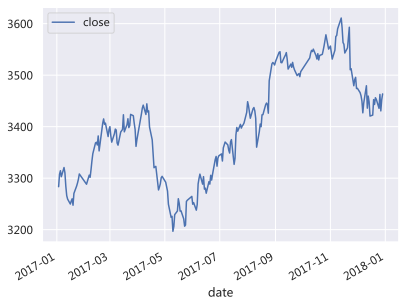

In [242]:
price_d.plot();

日线转周线：注意`resample`只能用在时间序列数据上。

In [243]:
price_w = price_d.resample('W').last()
price_w.head()

,close
date,
2017-01-08,3302.79
2017-01-15,3259.27
2017-01-22,3270.33
2017-01-29,3308.06
2017-02-05,3288.17


计算周回报率：在周线上调用方法`pct_change()`。

In [244]:
# 计算周回报率
price_w['return'] = price_w['close'].pct_change(fill_method=None).round(4)
price_w.head()

,close,return
date,,
2017-01-08,3302.79,NaN
2017-01-15,3259.27,-0.0132
2017-01-22,3270.33,0.0034
2017-01-29,3308.06,0.0115
2017-02-05,3288.17,-0.0060


同样的方法计算月线和月回报率。

In [245]:
# 转为月线：每月最后一天的收盘价
price_m = price_d.resample('ME').last()
price_m.head()

,close
date,
2017-01-31,3308.06
2017-02-28,3394.50
2017-03-31,3374.67
2017-04-30,3303.44
2017-05-31,3264.54


In [246]:
# 计算月回报率
price_m['return'] = price_m['close'].pct_change().round(4)
price_m.head()

,close,return
date,,
2017-01-31,3308.06,NaN
2017-02-28,3394.50,0.0261
2017-03-31,3374.67,-0.0058
2017-04-30,3303.44,-0.0211
2017-05-31,3264.54,-0.0118


In [247]:
# 简单验算
3394.50 / 3308.06 - 1

0.026130118558913784

## 上市公司净利润增长率
（原7.3小节，p143）

### 要求

从数据中找出连续3年，净利润增长率都在40%以上的公司。

1. `data2.xlsx`：利润表
2. `info.xlsx`：股票代码、简称和行业

### 思路和实现

1. `merge()`按代码列合并数据
2. `groupby()`按代码分组，`pct_change()`计算百分比变化（分组后显然就是每个股票自己和自己相比，利润的年度增长率）
3. `groupby()`按代码分组，循环每个组。


In [248]:
# 例行公事，一般一个ipynb或者.py文件最前面import一次即可
import pandas as pd
import numpy as np

df1 = pd.read_excel('data/case7.3/data2.xlsx',converters={'Stkcd':str, 'Accper':pd.to_datetime})
df1.head()

,Stkcd,Accper,B002000101
0,000016,2014-12-31,5.262353e+07
1,000016,2015-12-31,-1.256819e+09
2,000016,2016-12-31,9.567303e+07
3,000016,2017-12-31,5.057025e+09
4,000020,2014-12-31,7.687620e+06


In [249]:
df2 = pd.read_excel('data/info.xlsx',converters = {'Stkcd':str})
df2.head()

,Stkcd,Stknme,Nnindnme
0,000016,深康佳A,计算机、通信和其他电子设备制造业
1,000020,深华发A,计算机、通信和其他电子设备制造业
2,000021,深科技,计算机、通信和其他电子设备制造业
3,000045,深纺织A,计算机、通信和其他电子设备制造业
4,000050,深天马A,计算机、通信和其他电子设备制造业


In [250]:
# 检查一下数据，行业名称去重，查看有几个行业：
# 回忆作业1：我们做过自己的unique函数。
df2.Nnindnme.unique()

array(['计算机、通信和其他电子设备制造业'], dtype=object)

把2个数据按股票代码列进行合并，我们可以对这个新数据进行处理。

In [251]:
# merge两个数据，去掉行业列，因为行业全部相同。
profit_y = df1.merge(df2).drop('Nnindnme',axis=1)
profit_y.columns = ['股票代码','会计年度','净利润','股票简称']
profit_y.head()

,股票代码,会计年度,净利润,股票简称
0,000016,2014-12-31,5.262353e+07,深康佳A
1,000016,2015-12-31,-1.256819e+09,深康佳A
2,000016,2016-12-31,9.567303e+07,深康佳A
3,000016,2017-12-31,5.057025e+09,深康佳A
4,000020,2014-12-31,7.687620e+06,深华发A


求每只股票的年度净利润增长率：先按股票分组，再对净利润列调用`pct_change()`求百分比变化。

In [252]:
growth = profit_y.groupby('股票代码')['净利润'].pct_change()
profit_y['增长率'] = growth
profit_y.head(8)

,股票代码,会计年度,净利润,股票简称,增长率
0,000016,2014-12-31,5.262353e+07,深康佳A,NaN
1,000016,2015-12-31,-1.256819e+09,深康佳A,-24.883220
2,000016,2016-12-31,9.567303e+07,深康佳A,-1.076123
3,000016,2017-12-31,5.057025e+09,深康佳A,51.857375
4,000020,2014-12-31,7.687620e+06,深华发A,NaN
5,000020,2015-12-31,-4.200846e+06,深华发A,-1.546443
6,000020,2016-12-31,5.457710e+06,深华发A,-2.299193
7,000020,2017-12-31,9.744094e+05,深华发A,-0.821462


注意：假如不按股票分组，直接取净利润求增长率，那么就会出现某一只股票的第一个利润，减去前一只股票最后一个利润的情况。

如上表：

1. 第4行，深华发2014年的增速，因为我们没有2013年的数据，因此无法计算，结果显示NA是正确的。
2. 如果不分组，则会使用深华发2014年的利润（第4行）和深康佳2017年（第3行）进行比较，显然并不正确。

对分组进行循环，我们就可以更明显第看到这一点。

In [253]:
# 先罗列一下前几只股票
for i,x in profit_y.iloc[:12].groupby('股票代码'):
    display(x) # 类似于print()函数，display()也可以把数据显示出来，但对于DataFrame的显示比较好


,股票代码,会计年度,净利润,股票简称,增长率
0,000016,2014-12-31,5.262353e+07,深康佳A,NaN
1,000016,2015-12-31,-1.256819e+09,深康佳A,-24.883220
2,000016,2016-12-31,9.567303e+07,深康佳A,-1.076123
3,000016,2017-12-31,5.057025e+09,深康佳A,51.857375


,股票代码,会计年度,净利润,股票简称,增长率
4,000020,2014-12-31,7687620.27,深华发A,NaN
5,000020,2015-12-31,-4200845.61,深华发A,-1.546443
6,000020,2016-12-31,5457710.33,深华发A,-2.299193
7,000020,2017-12-31,974409.39,深华发A,-0.821462


,股票代码,会计年度,净利润,股票简称,增长率
8,000021,2014-12-31,1.756764e+08,深科技,NaN
9,000021,2015-12-31,1.806603e+08,深科技,0.028370
10,000021,2016-12-31,2.144235e+08,深科技,0.186888
11,000021,2017-12-31,5.413030e+08,深科技,1.524457


继续对分组数据进行循环，提取"增长率最后3个值全部大于等于0.4"的组。

In [254]:
# 开始循环每只股票的分组DataFrame
# 如果符合要求（三年净利润增速都>=0.4），添加到空列表result

result = []
for i,x in profit_y.groupby('股票代码'):
    if all(x['增长率'].tail(3) >= 0.4):
        result.append(x)

result = pd.concat(result)
result.head(8)


,股票代码,会计年度,净利润,股票简称,增长率
286,002383,2014-12-31,4.005807e+07,合众思壮,NaN
287,002383,2015-12-31,6.057712e+07,合众思壮,0.512233
288,002383,2016-12-31,9.644973e+07,合众思壮,0.592181
289,002383,2017-12-31,2.419267e+08,合众思壮,1.508319
310,002402,2014-12-31,4.505389e+07,和而泰,NaN
311,002402,2015-12-31,7.494657e+07,和而泰,0.663487
312,002402,2016-12-31,1.196604e+08,和而泰,0.596609
313,002402,2017-12-31,1.781037e+08,和而泰,0.488410


### 长表和宽表的转换

首先构造一个示例数据：这是一个最一般的时间序列数据：ABC个观察对象（人或者公司等等），在2022-01-01到2022-01-03这三天里的某个属性。

比如：3家上市公司3天的股价；3个人3天的心情指数；等等。

In [255]:
# 构造示例数据
df_long = pd.DataFrame({'date': list(pd.date_range('2022-01-01', '2022-01-03'))*3,
                        'name': ['A']*3 + ['B']*3 + ['C']*3,
                        'value': np.random.randint(1, 10, 9)})
df_long


,date,name,value
0,2022-01-01,A,2
1,2022-01-02,A,3
2,2022-01-03,A,8
3,2022-01-01,B,9
4,2022-01-02,B,2
5,2022-01-03,B,3
6,2022-01-01,C,3
7,2022-01-02,C,6
8,2022-01-03,C,9


这是一个“长数据 long data”：

1. 每一列是一个属性。
2. 每一行有1个或者多个观测值。比如第一行是被观察对象A在2022年1月1日的某个属性，值为3。

因为每一列都是一个属性，因此你可以通过简单的行筛选列来找到你要的值。

In [256]:
df_long[(df_long['date'] == "2022-01-02") &  (df_long['name'] == 'B')]

,date,name,value
4,2022-01-02,B,2


宽数据则不同：行标签表示某个（或者几个）属性的取值，列标签表示另一个（或者几个）属性的取值，表格的内容就是数据。

下表是个“宽数据”：

1. 行标签是日期，列标签是姓名
2. 行和列（日期-姓名）共同指示一个数据。

In [257]:
df_wide = df_long.pivot(index = 'date',columns = 'name',values = 'value')
df_wide

name,A,B,C
date,,,
2022-01-01,2,9,3
2022-01-02,3,2,6
2022-01-03,8,3,9


因此选择数据往往要同时选择行和列：

In [258]:
df_wide.loc['2022-01-02','B']

2

长数据转宽数据，使用 `.pivot()`，3个参数:

1. index: 选择那一列（或者几列），作为宽表的行标签（你希望行是什么？这里选择每行是一个人）
2. columns: 选择那一列（或者几列），作为宽表的列标签（你希望列是什么？这里选择每列是日期）
3. value: 行列所决定的数据。

In [259]:
df_long.pivot(index = 'name',columns = 'date',values = 'value')

date,2022-01-01,2022-01-02,2022-01-03
name,,,
A,2,3,8
B,9,2,3
C,3,6,9


注意，这个宽表和前面的宽表不同：行列正好对换。同样的长表，可能因为你选择不同的行或者列，可以形成不同的宽表，但含义是一样的。选择什么作为行和列，主要看对表格的要求，或者对后续分析的便利。

那么宽表转长表呢？用`.stack()`，恰好是长转宽反过来。

In [260]:
df_wide.stack().reset_index() # 注意列名是0，你要手动改一下，这里略

,date,name,0
0,2022-01-01,A,2
1,2022-01-01,B,9
2,2022-01-01,C,3
3,2022-01-02,A,3
4,2022-01-02,B,2
5,2022-01-02,C,6
6,2022-01-03,A,8
7,2022-01-03,B,3
8,2022-01-03,C,9


### 回到案例

查看我们的数据：

In [261]:
result.head(8)

,股票代码,会计年度,净利润,股票简称,增长率
286,002383,2014-12-31,4.005807e+07,合众思壮,NaN
287,002383,2015-12-31,6.057712e+07,合众思壮,0.512233
288,002383,2016-12-31,9.644973e+07,合众思壮,0.592181
289,002383,2017-12-31,2.419267e+08,合众思壮,1.508319
310,002402,2014-12-31,4.505389e+07,和而泰,NaN
311,002402,2015-12-31,7.494657e+07,和而泰,0.663487
312,002402,2016-12-31,1.196604e+08,和而泰,0.596609
313,002402,2017-12-31,1.781037e+08,和而泰,0.488410


我们可以转为：每行是“股票代码+名称”，每列是“会计年度”，数据是“增长率”

In [262]:
result.pivot(index=['股票代码', '股票简称'], columns=['会计年度'],
             values=['增长率']).dropna(axis=1).round(2)


增长率                      
会计年度        2015-12-31 2016-12-31 2017-12-31
股票代码   股票简称                                 
002383 合众思壮       0.51       0.59       1.51
002402 和而泰        0.66       0.60       0.49
002600 领益智造      11.95       4.08       5.00
300053 欧比特        1.31       0.46       0.43
300088 长信科技       0.43       0.46       0.57
300136 信维通信       2.51       1.40       0.67
300232 洲明科技       0.87       0.47       0.71
300296 利亚德        1.05       1.02       0.81
600260 凯乐科技       1.52       0.52       3.06
600330 天通股份       4.39       0.51       0.42
600667 太极实业       0.66       8.86       0.80

或者：每行“会计年度”，每列是“股票代码+名称”，数据是“增长率”

In [263]:
result.pivot(index=['会计年度'], columns=['股票代码', '股票简称'],
             values=['增长率']).dropna(axis=0).round(2)


增长率                                                          \
股票代码       002383 002402 002600 300053 300088 300136 300232 300296 600260   
股票简称         合众思壮    和而泰   领益智造    欧比特   长信科技   信维通信   洲明科技    利亚德   凯乐科技   
会计年度                                                                        
2015-12-31   0.51   0.66  11.95   1.31   0.43   2.51   0.87   1.05   1.52   
2016-12-31   0.59   0.60   4.08   0.46   0.46   1.40   0.47   1.02   0.52   
2017-12-31   1.51   0.49   5.00   0.43   0.57   0.67   0.71   0.81   3.06   

                          
股票代码       600330 600667  
股票简称         天通股份   太极实业  
会计年度                      
2015-12-31   4.39   0.66  
2016-12-31   0.51   8.86  
2017-12-31   0.42   0.80

## 股票价、量走势图的绘制
（原7.4小节 p145）


### 要求

绘制股价的走势曲线、日成交量柱状图、月成交量的饼图，以及三图并列。

数据：

1. `trd.xlsx`：3只股票的股价序列：长数据（回忆上一节）




In [264]:
df = pd.read_excel(
    'data/case7.4/trd.xlsx', converters={'股票代码': str, '交易日期': pd.to_datetime})
df.head()


,股票代码,交易日期,收盘价,交易量
0,600000,2017-01-03,16.30,16237125
1,600000,2017-01-04,16.33,29658734
2,600000,2017-01-05,16.30,26437646
3,600000,2017-01-06,16.18,17195598
4,600000,2017-01-09,16.20,14908745


In [265]:
# 看一下都有什么股票
df['股票代码'].unique()

array(['600000', '600004', '600005'], dtype=object)

### 价格曲线

问题1： 绘制600000股票，'2017-01-03':'2017-01-20'之间的收盘价

1. 选股，选列，形成时间序列数据
2. 筛选时间段
3. 绘图

Text(0.5, 1.0, '600000价格走势图')

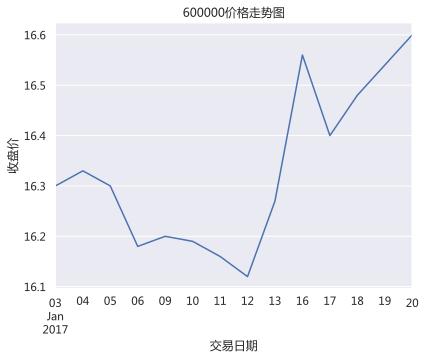

In [266]:
code = '600000'

x = df.query('股票代码 == @code ')[['交易日期', '收盘价']
                               ].set_index('交易日期').loc['2017-01-03':'2017-01-20']
p1 = x.plot(legend=None)  # 绘图时去掉 legend
# plt.xlim(('2016-12-31','2017-01-22'))
plt.ylabel('收盘价')
plt.title(f'{code}价格走势图')


### 日交易量
问题2：绘制60000,1月份的交易量柱状图

1. 选股，选列，构造时间序列数据
2. 选择时间段
3. 绘图

（和上一题没什么区别）

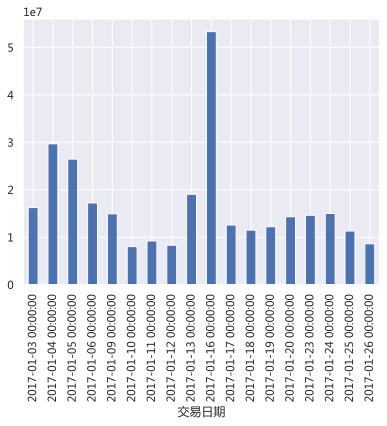

In [267]:
y = df.query('股票代码 == @code ')[['交易日期','交易量']].set_index('交易日期').loc['2017-01']
p2 = y['交易量'].plot.bar();


注意到，因为我们的index用的是`datetime`格式（`pd.to_datetime`），含有日期和时间信息，但我们只想显示日期，或者“月-日”，可以考虑日期格式化。

1. 对于`DatetimeIndex`数据（索引中的日期），调用`.strftime()`。
2. 对于`Series`数据（普通列中的日期），则是`.dt.strftime()`

参数是格式化字符串，常用的符号包括：

1. %y 两位数的年份表示（00-99）
2. %Y 四位数的年份表示（000-9999）
3. %m 月份（01-12）
4. %d 月内中的一天（0-31）
5. %H 24小时制小时数（0-23）
6. %I 12小时制小时数（01-12）
7. %M 分钟数（00=59）
8. %S 秒（00-59）

如"%Y-%m-%d"就是四位数的年-月-日。

In [268]:
# y是一个时间序列数据，index是datetime格式，包含日期和时间数据（顾名思义）
y.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16', '2017-01-17', '2017-01-18',
               '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26'],
              dtype='datetime64[ns]', name='交易日期', freq=None)

In [269]:
# 格式化为'月-日'，看看效果
y.index.strftime("%m-%d")

Index(['01-03', '01-04', '01-05', '01-06', '01-09', '01-10', '01-11', '01-12',
       '01-13', '01-16', '01-17', '01-18', '01-19', '01-20', '01-23', '01-24',
       '01-25', '01-26'],
      dtype='object', name='交易日期')

使用`p.set_xticklabels()`，把x坐标的标签（x坐标刻度上的文字），设置为你指定的列表。

Text(0.5, 0, '')

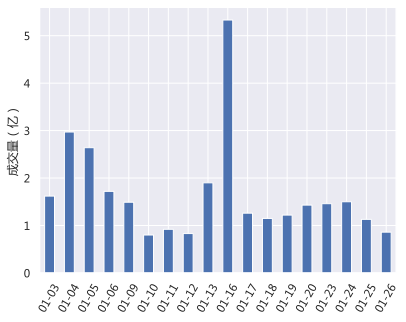

In [270]:
y = df.query('股票代码 == @code ')[['交易日期','交易量']].set_index('交易日期').loc['2017-01']
y['交易量_亿'] = round(y['交易量']/10000000,2)
p2 = y['交易量_亿'].plot.bar();

p2.set_xticklabels(y.index.strftime("%m-%d")); # 改一下横坐标刻度上的标签

# 其他部分
plt.xticks(rotation=60); 
plt.ylabel('成交量（亿）')
plt.xlabel('')

### 月成交量饼图

问题3：绘制股票60000，从1月到11月的成交量的饼图

1. 选择列：交易日期和交易量，设置为时间序列数据
2. `.resample('ME').sum()`重采样为月并求和：得到月交易量的和。
3. 生成一列“月”：1-11月
4. 绘图！

In [271]:
code = '600000'

x = df.query('股票代码 == @code ')[['交易日期','交易量']].set_index('交易日期').resample("ME").sum().reset_index()
x

,交易日期,交易量
0,2017-01-31,302255420
1,2017-02-28,278793913
2,2017-03-31,446555984
3,2017-04-30,426042150
4,2017-05-31,1086178385
5,2017-06-30,1330750427
6,2017-07-31,1317190884
7,2017-08-31,1369766042
8,2017-09-30,742796792
9,2017-10-31,522531066


In [272]:
# 用时间方法`.dt.month()`，从交易日期列（Series）中提取月
trade_month = pd.Series(x['交易日期'].dt.month,name='月')
trade_month

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
Name: 月, dtype: int32

几个参数：

1. `textprops`：改标签的字体属性，这里改字号为10号。
2. `pctdistance`：百分比标签的位置：从圆心为0，到圆周为1。

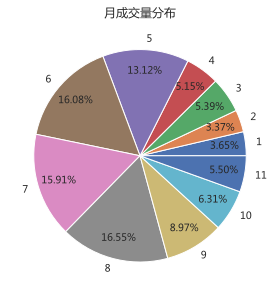

In [273]:
# 绘图！标签字体10号，百分比放在0.8的位置上
p3 = x.set_index(trade_month)['交易量'].plot.pie(
    autopct='%.2f%%', textprops={'fontsize': 10}, pctdistance=0.8);

plt.ylabel('')
plt.title('月成交量分布');

三图并列比较简单，这里略过。可以参考绘图章节的内容，下一个案例中也有更复杂的例子。

## 股票价格移动平均线的绘制
（原7.5小节 p149）

### 要求

对数据中所有的股票，绘制股票的价格和10日均线。绘图4个一组，并按2x2的格式排列，绘制全部股票。

数据：

1. `trd.xlsx`：股票代码、交易日、收盘价的数据（长表），注意和前面有个数据重名，这份数据在`data/case7.5`目录下。

### 原理和实现

依然贯彻我们的思路：

先按目标，把数据制作成符合要求的1个DataFrame，再对这个成品DF进行其他处理，如统计、绘制等。避免把数据整理、列运算、分析和绘制写在一段代码中！

1. 测试如何绘制1只股票的价格和均线。
2. 绘制4只股票在一张图中，写成一个函数。
3. 把股票代码4个一组，分成n段，形成一个列表。
4. 循环上述列表，调用第2步的函数。


### 读取数据

In [274]:
df = pd.read_excel('data/case7.5/trd.xlsx',
                    converters={'Stkcd':str,'Trddt':pd.to_datetime})
df.head()

,Stkcd,Trddt,Clsprc
0,002001,2016-05-03,20.99
1,002001,2016-05-04,20.42
2,002001,2016-05-05,20.49
3,002001,2016-05-06,18.70
4,002001,2016-05-09,18.67


把列名改为有意义的名字，然后转为时间序列数据。

In [275]:
df.columns = ['code','date','close'] # 代码，日期，收盘价
df.set_index('date',inplace = True)
df.head()

,code,close
date,,
2016-05-03,002001,20.99
2016-05-04,002001,20.42
2016-05-05,002001,20.49
2016-05-06,002001,18.70
2016-05-09,002001,18.67


看看都有什么股票

In [276]:
df.code.unique()

array(['002001', '002002', '002003', '002004', '002005', '002006',
       '002007', '002008', '002009', '002010', '002011', '002012',
       '002013', '002014', '002015', '002016', '002017', '002018',
       '002019', '002020'], dtype=object)

### 绘制1只股票

要把4只股票绘制成2x2的样式，我们首先尝试绘制1只股票。

以某1只股票为例，绘制股价和10日均线：筛选数据、计算10ma、选列绘图。

<Axes: xlabel='date'>

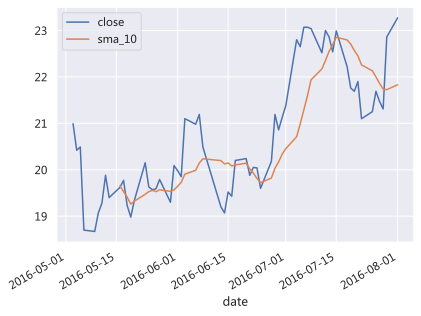

In [277]:
# 简单移动平均
def sma(x:pd.Series, period):
    return x.rolling(period).mean()

code = '002001'

tmp_df = df.query('code == @code').copy() 
# query创建了一个视图
# 但我们这里的意图是把@code的数据拷贝出来到tmp_df中，而不是修改df中的数据
# 因此需要显式地copy()
# 此时tmp_df是一个独立的对象，而非指向df中部分数据的视图

tmp_df['sma_10'] = sma(tmp_df.query('code == @code').close,10)

tmp_df[['close','sma_10']].plot()

上图正式我们想要的。


要对所有股票都计算其10日MA，显然可以分组进行：

1. 按股票分组，取收盘价
2. 对每一组的收盘价格，应用前面的`sma()`函数
3. 结果写入`df['sam_10']`

In [278]:
# 简单测试下：取子集、取close列，应用sma函数，参数是10天
df.groupby('code').close.apply(lambda x: sma(x,10)).head(15)

code    date      
002001  2016-05-03       NaN
        2016-05-04       NaN
        2016-05-05       NaN
        2016-05-06       NaN
        2016-05-09       NaN
        2016-05-10       NaN
        2016-05-11       NaN
        2016-05-12       NaN
        2016-05-13       NaN
        2016-05-16    19.652
        2016-05-17    19.530
        2016-05-18    19.411
        2016-05-19    19.260
        2016-05-20    19.324
        2016-05-23    19.472
Name: close, dtype: float64

In [279]:
# 把前面做的数据没问题吃，因此可以加入到df中
df['sma_10'] = df.groupby('code').close.apply(lambda x: sma(x,10)).values

随便选1只股票来测试一下

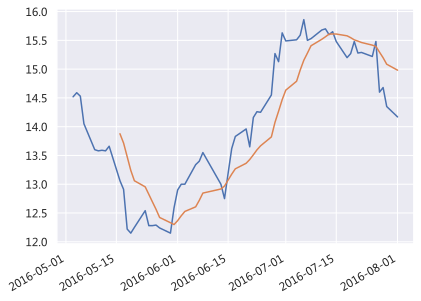

In [280]:
df.query('code == "002003"')[['close','sma_10']].plot()
plt.xlabel('')
plt.legend('',frameon=False); # 图例无内容，且无边框 = 隐藏图例

### 绘制2x2的子图：手动版本

注：

1. 下列代码明显有很大的重复，因此必然可以改造成循环（或者列表推导式）。
2. 如果你要绘制的股票有3000多个，不可能手动填写股票代码。

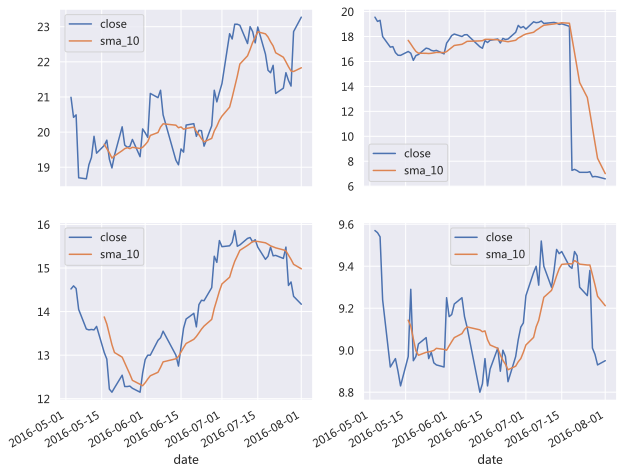

In [281]:
# 在画布上生成2x2=4个坐标系
fig, axes = plt.subplots(2, 2,figsize = (10,8), sharex=True)

# 随便拿4只股票，绘制到对应的ax上
df.query('code == "002001"')[['close','sma_10']].plot(ax=axes[0,0])
df.query('code == "002002"')[['close','sma_10']].plot(ax=axes[0,1])
df.query('code == "002003"')[['close','sma_10']].plot(ax=axes[1,0])
df.query('code == "002004"')[['close','sma_10']].plot(ax=axes[1,1]);

### 绘制2x2的子图：自动版

问：已知任意4只股票的代码，绘制2x2的图形。

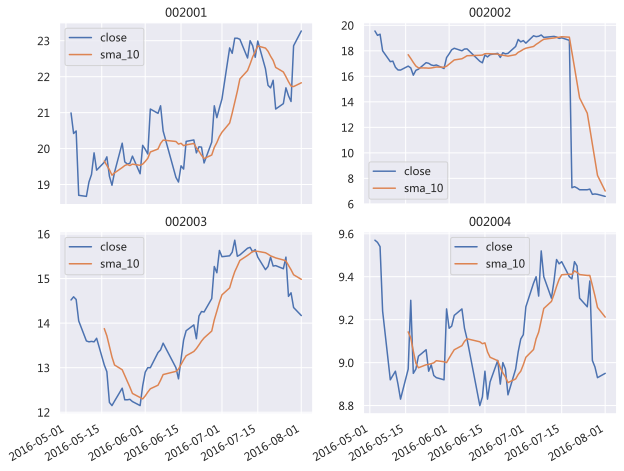

In [282]:
# 范例股票代码：
code_list = ['002001','002002','002003','002004']

# 设置画布：2行，2列，共用x轴
fig, axes = plt.subplots(2, 2,figsize = (10,8), sharex=True)

# 把2维的ndarray转为1维。 如：[[1, 2], [3, 4]] -> [1, 2, 3, 4]
# 因此，axes_1d[0]和axes[0,0]，都指向左上角的坐标系。
axes_1d = axes.flatten() 

# 循环这个代码列表
for i in range(len(code_list)):
    code = code_list[i]

    # 第i个股票代码，绘制在第i个坐标系
    df.query('code == @code ')[['close','sma_10']].plot(ax=axes_1d[i])

    # 去掉横轴标签，股票代码作为子图标题
    axes_1d[i].set(xlabel='',title = code)

plt.subplots_adjust(hspace=0.15)

我们可以把前面的内容，整理成一个函数，参数应该是：

1. 数据源df
2. 要绘制的4只股票的代码

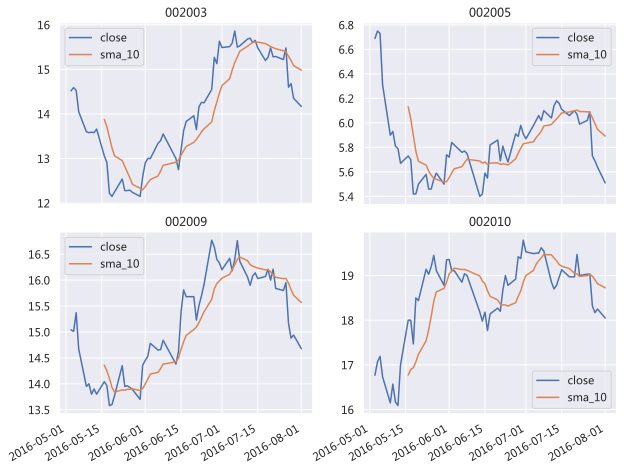

In [283]:
# 为了节约篇幅，这里删除了注释，注释内容同前。
# 但正常情况下注释是必须的！

def plot2x2(df, code_list):
    '''绘制4个股票的价格和MA
    
        df: 全部股票的数据
        code_list: 4只股票的代码
    '''
    fig, axes = plt.subplots(2, 2,figsize = (10,8), sharex=True)
    axes_1d = axes.flatten()

    for i in range(len(code_list)):
        code = code_list[i]
        df.query('code == @code ')[['close','sma_10']].plot(ax=axes_1d[i])
        axes_1d[i].set(xlabel='',title=code)

    plt.subplots_adjust(hspace=0.15)

# 随便测试4个代码
plot2x2(df, ['002003','002005','002009','002010'])

把所有的股票代码取出，每4个代码成一组，分成n/4段：

In [284]:
all_codes = df.code.unique()

np.array_split(all_codes,len(all_codes)/4 ) # 股票代码的序列，切成4个代码一组List的List

[array(['002001', '002002', '002003', '002004'], dtype=object),
 array(['002005', '002006', '002007', '002008'], dtype=object),
 array(['002009', '002010', '002011', '002012'], dtype=object),
 array(['002013', '002014', '002015', '002016'], dtype=object),
 array(['002017', '002018', '002019', '002020'], dtype=object)]

简单循环上面的分段列表。显然，每一段就是4个股票代码，在循环体内调用`plot2x2()`即可。

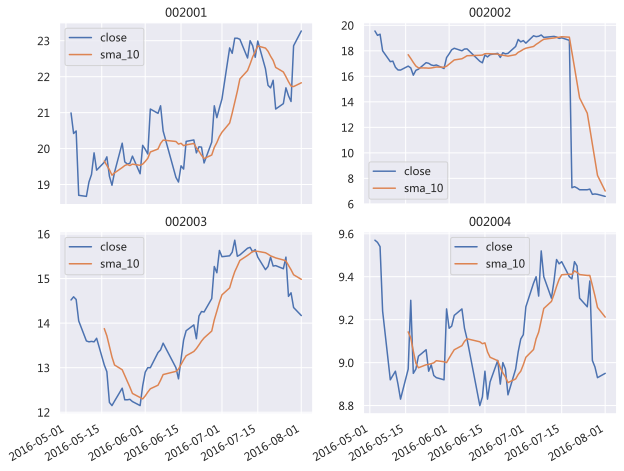

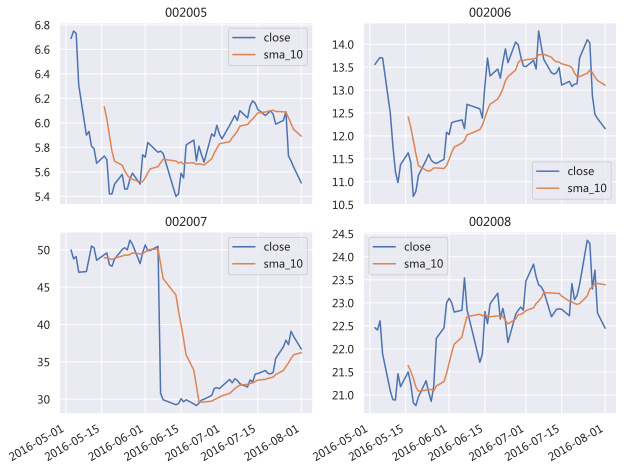

In [285]:
# 节约篇幅，这里以前2段（8只股票）为例
for x in np.array_split(all_codes,len(all_codes)/4 )[:2]:
    plot2x2(df,x)

## 沪深300指数走势预测
（原7.6小节 p154）

### 要求

利用沪深300指数的数据，利用几个分类模型，对指数的涨跌进行预测。 需要前置章节：分类和预测。

### 数据：

1. `index300.xlsx`：沪深300指数的数据。

### 大致原理：

1. 指数的k线数据，对次日涨跌进行预测。
2. 如果把次日涨跌看作2种类别，则这个任务可以看成是分类预测问题
3. 这本质和用叶片萼片数据判断鸢尾花的品种类似：今天走势类比叶片萼片数据，明天的涨跌类比鸢尾花的品种
4. 用数据拟合一个模型，对新观测进行判断：对一朵不知品种的鸢尾花，观测叶片萼片的数据，判断（预测）其品种；对一个新的价格时间序列，观察其历史数据，判断（预测）明天的涨跌。
5. 或者说把价格走势数据分成2类：明天会涨/明天会跌，对新的数据预测其类别。


数据读取和清洗

In [286]:
df = pd.read_excel('data/case7.6/index300.xlsx')
df.head()

,Indexcd,Idxtrd01,Idxtrd02,Idxtrd03,Idxtrd04,Idxtrd05,Idxtrd06,Idxtrd07,Idxtrd08
0,300,2014-01-02,2323.43,2325.99,2310.65,2321.98,451942.91,4901221.11,-0.3454
1,300,2014-01-03,2311.97,2314.84,2280.89,2290.78,597826.45,5773970.99,-1.3436
2,300,2014-01-06,2286.37,2286.37,2229.33,2238.64,663004.03,5997936.01,-2.2762
3,300,2014-01-07,2222.31,2246.79,2218.65,2238.00,437531.03,4256564.81,-0.0284
4,300,2014-01-08,2240.64,2262.58,2228.42,2241.91,513488.54,5069148.89,0.1747


改个合理的列名，转为时间序列格式。

In [287]:
df.columns = ['code','date','open','high','low','close','vol','xxx','ret'] # 倒数第二列不知道是什么
df.set_index('date',inplace=True)
df.tail()

,code,open,high,low,close,vol,xxx,ret
date,,,,,,,,
2014-12-25,300,3254.48,3335.78,3226.32,3335.42,3097995.47,33012893.99,3.2514
2014-12-26,300,3343.64,3453.34,3335.01,3445.84,3846141.24,43883842.71,3.3105
2014-12-29,300,3502.18,3524.28,3405.84,3455.46,4250150.37,50500450.84,0.2791
2014-12-30,300,3450.81,3491.83,3422.17,3457.55,3282338.73,39460777.24,0.0607
2014-12-31,300,3462.39,3542.34,3452.50,3533.71,3459347.60,40371088.81,2.2025


这个案例中，使用如下信息来进行分类（预测明天走势，见变量注释）

In [288]:
def sma(x:pd.Series, period):
    return x.rolling(period).mean()

# 收盘价的10日均线
ma10 = sma(df.close,10) 

A1 = df.close / ma10 # 收盘价相对10日均线
A2 = df.vol / sma(df.vol,10) # 成交量相对10日成交量的均值
A3 = df.ret # 回报率
A4 = df.high / ma10 # 最高价相对10日均线
A5 = df.low / ma10 # 最低价相对10日均线
A6 = df.high - df.low # 最高价和最低价之差
A7 = df.close - df.open # 收盘价相对开盘价

data = pd.concat([A1,A2,A3,A4,A5,A6,A7],axis=1)
data.columns = ['A' + str(i) for i in range(1,8)]
data.tail()

,A1,A2,A3,A4,A5,A6,A7
date,,,,,,,
2014-12-25,1.008022,0.834703,3.2514,1.008131,0.975050,109.46,80.94
2014-12-26,1.033503,1.013465,3.3105,1.035752,1.000262,118.33,102.20
2014-12-29,1.029035,1.081501,0.2791,1.049530,1.014258,118.44,-46.72
2014-12-30,1.024952,0.841631,0.0607,1.035114,1.014464,69.66,6.74
2014-12-31,1.042181,0.910890,2.2025,1.044726,1.018230,89.84,71.32


模型要拟合的结果，是“明天的涨跌”：

1. `df.ret`是今天的涨跌幅度，判断是否大于0（今天的涨跌），再取一阶提前`shift(-1)`（明天的涨跌）
2.  去掉缺失值。

In [289]:
data['y'] = ((df.ret > 0)*1).shift(-1) # 明天的涨跌

data.tail() # 看看最后一行是不是NA

,A1,A2,A3,A4,A5,A6,A7,y
date,,,,,,,,
2014-12-25,1.008022,0.834703,3.2514,1.008131,0.975050,109.46,80.94,1.0
2014-12-26,1.033503,1.013465,3.3105,1.035752,1.000262,118.33,102.20,1.0
2014-12-29,1.029035,1.081501,0.2791,1.049530,1.014258,118.44,-46.72,1.0
2014-12-30,1.024952,0.841631,0.0607,1.035114,1.014464,69.66,6.74,1.0
2014-12-31,1.042181,0.910890,2.2025,1.044726,1.018230,89.84,71.32,NaN


在一个序列进行了滞后/提前运算之后，检查一下开头和结尾：

1. 要用今天的信息，预测明天的涨跌，那么数据最后一天必然没有明天的涨跌信息的。看y的末尾是否为NA。
2. 同理，如果是做了滞后运算，最好看一样第一天的数据是否为NA。

### 模型的拟合与预测

把数据成4份：

![](images/train_test.png)

数据本身由2个部分组成：（X是大写，表示矩阵；y是小写，表示向量）

1. X：信息特征（影响涨跌的因素），即A1-A7
2. y：二元标签（明天的涨跌）

把上述2个数据，前后截断。前半截数据用来训练模型：

1. X_train：训练模型用的特征信息
2. y_train：训练模型用的二元标签

后半截数据用来对模型进行样本外预测：

1. X_test：新的特征信息，用上面生成的模型预测明天的涨跌pred_test
2. y_train：把预测值pred_dest和真实的涨跌对比，衡量模型样本外的预测能力。

我们可以用对test数据的预测，来判断模型（或者特定参数）的预测准确性。

In [290]:
data.dropna(inplace = True)
X = data.drop('y',axis=1)
y = data['y']

test_size = X.shape[0]//6
print(f"{test_size=}")

X_train = X[:-test_size].copy()
y_train = y[:-test_size].copy()

assert len(X_train) == len(y_train)

X_test = X.iloc[-test_size:].copy()
y_test = y.iloc[-test_size:].copy()

assert len(X_test) == len(y_test)


test_size=39


训练模型，再用测试数据进行预测测试：以Logistic模型为例：

In [291]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

model = LogisticRegression() # 使用Logistic模型


model.fit(X_train,y_train) # 用训练数据拟合模型

pred_train = model.predict(X_train) # 用训练好的模型，对训练数据进行预测
pred_test = model.predict(X_test) # 用训练好的模型，对测试数据进行预测

acc_train = (y_train == pred_train).mean() # 训练数据的准确率
acc_test = (y_test == pred_test).mean() # 测试数据的准确率

print(f'model: {type(model).__name__}, {acc_train=:.2f}, {acc_test=:.2f}')


model: LogisticRegression, acc_train=0.58, acc_test=0.72


注意，X_test 是“新数据”，我们假装不知道真实的结果。

对于任何新的数据，要做预测（进行分类），只要`model.predict(X_test)`即可


In [292]:
pred_test = model.predict(X_test)
pred_test # 显示预测值

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [293]:
X_test_with_pred = X_test.copy()
X_test_with_pred['pred'] = pred_test
X_test_with_pred.tail()

,A1,A2,A3,A4,A5,A6,A7,pred
date,,,,,,,,
2014-12-24,0.980798,0.842313,-2.8433,1.014186,0.968079,151.86,-101.76,1.0
2014-12-25,1.008022,0.834703,3.2514,1.008131,0.975050,109.46,80.94,1.0
2014-12-26,1.033503,1.013465,3.3105,1.035752,1.000262,118.33,102.20,1.0
2014-12-29,1.029035,1.081501,0.2791,1.049530,1.014258,118.44,-46.72,1.0
2014-12-30,1.024952,0.841631,0.0607,1.035114,1.014464,69.66,6.74,1.0


因此，如果你有新的数据，同样构造一个类似结构DF，然后调用`model.predict()`即可。

比较3种模型：LogisticRegression，SVC，MLPClassifier（具体原理不展开）

不同的模型有完全相同的接口，因此可以写成函数，以使用何种模型作为参数。

In [294]:
def do_test(model):
    
    model.fit(X_train,y_train) # 用训练数据拟合模型

    pred_train = model.predict(X_train) # 用训练好的模型，对训练数据进行预测
    pred_test = model.predict(X_test) # 用训练好的模型，对测试数据进行预测

    acc_train = (y_train == pred_train).mean() # 训练数据的准确率
    acc_test = (y_test == pred_test).mean() # 测试数据的准确率

    print(f'model: {type(model).__name__} \n\t {acc_train=:.2f}, {acc_test=:.2f}')


do_test(LogisticRegression())
do_test(SVC(kernel='rbf'))
do_test(MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(5,2),random_state=1))

model: LogisticRegression 
	 acc_train=0.58, acc_test=0.72
model: SVC 
	 acc_train=0.58, acc_test=0.72
model: MLPClassifier 
	 acc_train=0.52, acc_test=0.69


可以看到3个模型的样本外预测的能力。

## 基于主成分聚类的上市公司盈利能力分析
（原7.7小节 p157）

需要前置章节：因子分析、聚类

### 快速回顾：主成分和K-means聚类

> **主成分**

主要用于降维，缩减变量的数据，或者说把样本的某些**高度相关**的属性合并，但又不希望损失太多信息。

一个极端的例子：如果$x_1,x_2$相关性达到0.99，那么可以认为他们几乎表示相同的信息，即使把这2个变量用某种方法变成1个（比如求平均或者直接去掉一个），显然不会有什么损失。

例如：同学成绩 $[语文,英语,数学,物理]$，有4个变量。按主成分分析，（可能）可以把4个变量合成2个变量（2个主成分）。如

$$
x_1 = a * 语文 + b * 英语
$$
$$
x_2 = c * 数学 + c * 物理
$$
（显然这是2个线性回归）

那么我们用2个变量 $[x_1, x_2]$，来表达原来4个变量所表达的大部分信息（多少算大部分？80？90%？由你决定）。

这个计算的过程是自动的，每个主成份由什么因素构成，其实是电脑计算的结果。

如果计算的结果，确实是$x_1$中语文和英语占了大部分（但数学和物理的系数一般不是0），$x_2$中数学和物理占了大部分（语文和英语的系数一般也不是0），那么我们可以考虑称$x_1$为“文科”，$x_2$为“理科”。

变量由多变少，就是所谓降维，往往**极大地**加快矩阵运算的速度。并且主成分往往是有意义的（如文科、理科），这对我们进行其他分析可能有帮助。


当然，如果变量之间没什么关联性，那么这一切也无从谈起了。


> **K-means聚类**

把样本，按他们各个变量之间的“距离”进行归类，但需要由你指定分成多少类。

<!-- ![](https://miro.medium.com/max/1400/1*fz-rjYPPRlGEMdTI-RLbDg.png) -->


![](images/kmeans.gif)

图片来自 [Applied Data Analysis in Python](https://milliams.com/courses/applied_data_analysis/appendix_clustering.html)


基本原理：

1.	给定K个聚类数量（要分K类）
2.	确定每个聚类的初始中心（也可以让Python自己定）
3.	对于所有的点，计算到K个中心点的距离（欧氏距离），划分到最近的一个点，构成一组。（这么多个中心，最靠近哪个中心，就算进那一组）
4.	迭代：对于上述过程中划分好的K个类别，重新计算新的中心点（均值），再次进行最邻近的划分，重复这个过程N次。

一个迭代2轮的示例：

![](images/kmeans_step.jpg){width=500px}


但要注意：这完全是一个“亲疏远近”的分类方法：相近的就会被归为一类，本身没有“好坏”的含义。但其中的指标可能有好坏，这需要分类后判断。


### 要求

1. 对于计算机行业的公司，对其财务数据进行降维，用k-means聚类，再计算每一类的利润增长率，以判断计算机行业中不同公司的水平层次。

数据：

1. `财务指标数据.xlsx`
2. `申万行业分类`

### 原理和实现

1. 对上市公司的一系列数据的进行降维。
2. 对降维后的数据进行K-means聚类，分出4类。
3. 计算每一类的利润增长率，进而判断每一类的优劣。

注意：对财务报表的指标进行进行k-means聚类可能不是一个好的做法，因为同一个行业里的公司，他们经营业绩往往是连续分布的，而不是“扎堆分布”的。而k-means聚类是一个基于距离的算法，能够把各自聚集的样本分开来，但是对连续分布的样本可能没什么办法。


### 读取数据

In [295]:
# 读取财务指标
# 其中的指标的含义见教材p157-p158，但暂时不重要

df = pd.read_excel('data/case7.7/财务指标数据.xlsx',
                converters = {'Stkcd':str,'Accper':pd.to_datetime})
df.round(4).head()

,Stkcd,Accper,F050502B,F050102B,F050202B,F051201B,F051501B,F053301B,F051401B,F052101B
0,000667,2015-12-31,0.0725,0.0306,0.0255,0.0453,0.0908,0.2879,0.1257,0.1607
1,000838,2015-12-31,0.0755,0.0206,0.0196,0.0257,0.1161,0.3483,0.0666,0.1125
2,600816,2015-12-31,0.4245,0.2844,0.2844,0.1880,0.6665,NaN,0.8924,NaN
3,600358,2015-12-31,0.0422,0.0475,0.0176,0.0514,0.1459,0.8675,0.3936,0.2412
4,601155,2015-12-31,0.1837,0.0426,0.0404,0.0936,0.1018,0.2681,0.1388,0.1728


In [296]:
df.Accper.unique() # 只有1天，因此日期是非必须的

<DatetimeArray>
['2015-12-31 00:00:00']
Length: 1, dtype: datetime64[ns]

In [297]:
df.Stkcd.unique().shape  # 接近3000只股票

(2842,)

读取行业分类

In [298]:
ind_info_df = pd.read_excel('data/case7.7/申万行业分类.xlsx',
                converters={'股票代码':str})
ind_info_df

,行业名称,股票代码,股票名称,起始日期,结束日期
0,采掘,000552,靖远煤电,2008-06-02 00:00:00,NaN
1,采掘,000571,新大洲A,2011-10-10 00:00:00,NaN
2,采掘,000629,攀钢钒钛,2015-10-31 00:00:00,NaN
3,采掘,000655,*ST金岭,2015-10-31 00:00:00,NaN
4,采掘,000723,美锦能源,2008-06-02 00:00:00,NaN
...,...,...,...,...,...
3566,综合,600817,ST宏盛,2016-08-04 01:33:00,NaN
3567,综合,600818,中路股份,2015-08-04 00:00:00,NaN
3568,综合,601992,金隅集团,2017-06-29 00:00:00,NaN
3569,综合,603060,国检集团,2016-11-06 18:27:00,NaN


按股票代码merge，去掉na，去掉日期，重置index，最终获得我们要的数据：计算机板块中的每一只股票和它的8个指标。

(这部分的操作请回忆我们的作业)

我们的任务，就是利用这8个指标，对股票进行K-means聚类。


In [299]:
data = pd.merge(df, ind_info_df.iloc[:, :3], left_on='Stkcd',
                right_on='股票代码').query('行业名称 == "计算机"').dropna().drop(['Accper', 'Stkcd', '行业名称'], axis=1).reset_index(drop=True)
data.head()


,F050502B,F050102B,F050202B,F051201B,F051501B,F053301B,F051401B,F052101B,股票代码,股票名称
0,0.321397,0.228925,0.227827,0.188137,0.474756,0.715053,0.557304,1.357928,002280,联络互动
1,0.154194,0.091206,0.093423,0.120079,0.154341,0.434843,0.136904,0.210119,300271,华宇软件
2,0.106211,0.076708,0.071280,0.077224,0.117922,0.499746,0.131880,0.180142,300324,旋极信息
3,0.083760,0.058820,0.064392,0.055300,0.174578,0.488951,0.119061,0.212990,002230,科大讯飞
4,0.184059,0.112991,0.102916,0.096451,0.265636,0.562932,0.244306,0.403114,300367,东方网力


先把股票的代码和名称，以及8个指标分开。

In [300]:
code_name = data.iloc[:,-2:]
code_name.head()

,股票代码,股票名称
0,002280,联络互动
1,300271,华宇软件
2,300324,旋极信息
3,002230,科大讯飞
4,300367,东方网力


In [301]:
X = data.iloc[:,:-2]
X.shape

(154, 8)

对于上述X

1. 保留所有大于0的值（等价于把小于0的值标记为NA）：`X[X>0]`
3. 对于每个属性，去掉8倍以上的观测值。
2. 去掉所有包含NA的行：等于去掉原数据中有缺失值的行、有小于0的值的行、以及有属性大于均值8倍的行。

In [302]:
X = X[X>0]
assert all(X>0)
X = X.apply(lambda c: c[c<8*c.mean()])
X = X.dropna()
X.shape

(130, 8)

只剩下130个样本了。

### 归一化和主成分分析

先进行归一化：对于8个指标，在每一个指标中（每一列中），我们把指标值映射到0到1之间（最低者为0，最高者为1，其他值按比例排在其中）。

确保每一列从0到1分布。

In [303]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

mms = MinMaxScaler()

X2 = mms.fit_transform(X)

对X2进行归一化之后，可以进行主成分分析，要求提取3个主成分（8个变量要求缩减到3个）

注意：参数`n_components`是你要提取几个主成分的意思。

In [304]:
pca = PCA(n_components=3) # 提取3个主成分
Y = pca.fit_transform(X2) # 获得新的数据

Y.shape


(130, 3)

依然是130个样本，8个变量缩减3个。

In [305]:
Y[:5]

array([[ 1.90412959, -0.08066129, -0.39295183],
       [ 0.27675405,  0.16340431,  0.08202221],
       [ 0.03642993, -0.02642522,  0.08086289],
       [-0.04285748, -0.15449534, -0.0091774 ],
       [ 0.53442846, -0.07900558, -0.07085411]])

查看特征向量

In [306]:
pca.components_

array([[ 3.58255463e-01,  3.77691621e-01,  4.02468928e-01,
         4.33683168e-01,  3.74982333e-01,  2.69608274e-01,
         3.20458085e-01,  2.50890372e-01],
       [ 3.59350970e-01,  1.89711676e-01,  1.43431475e-01,
         4.05273047e-01, -3.45833039e-01, -6.58048499e-01,
        -2.33127415e-01, -2.07559198e-01],
       [ 6.72839854e-02,  2.12912321e-02, -5.80726287e-04,
         3.20028729e-01, -3.32783213e-01,  6.80068064e-01,
        -4.71299118e-01, -3.11834454e-01]])

查看每个主成分的贡献率和总的贡献率

In [307]:
pca.explained_variance_ratio_

array([0.67847685, 0.20913697, 0.07212103])

In [308]:
sum(pca.explained_variance_ratio_)

0.9597348490623553

第一个主成分包含了原数据68%左右的信息，第二个包含了21%左右，第三个包含了7.2%左右，合计解释了96%的信息。

等于说，我们用3个变量，就涵盖了原来8个变量96%的信息。

（见参考教材p160-p161，这几个数字与教材相同。）

我们把提取的3个主成分绘制成3d图形

In [309]:
Y_df = pd.DataFrame(Y)
Y_df.columns = ['y1','y2','y3']
Y_df.head()

,y1,y2,y3
0,1.904130,-0.080661,-0.392952
1,0.276754,0.163404,0.082022
2,0.036430,-0.026425,0.080863
3,-0.042857,-0.154495,-0.009177
4,0.534428,-0.079006,-0.070854


In [310]:
import plotly.express as px
fig = px.scatter_3d(Y_df, x='y1', y='y2', z='y3', opacity=0.7)
fig.show()

从任何一个角度看，计算机上市公司的财务数据，并没有显示出“分类聚集”的情况（见快速回顾的图），因此k-means来进行分析，可能不是一个好主意。

### k-means聚类分析

虽然可能不是个好办法，但是过程还是可以做一下。

In [311]:
from sklearn.cluster import KMeans

# 创建一个k-means模型，要求
# 分成5类，初始状态是0（这个不用管），最大循环次数1000次
model = KMeans(n_clusters=5,random_state=0,max_iter=1000)

# 用这个模型对主成分数据进行分类
model.fit(Y) 

# 查看分类的结果
model.labels_


array([3, 4, 0, 0, 3, 0, 1, 2, 0, 4, 2, 2, 4, 4, 2, 1, 1, 2, 2, 0, 0, 4,
       2, 0, 1, 1, 4, 1, 3, 2, 2, 4, 1, 4, 2, 2, 2, 0, 1, 3, 0, 0, 2, 2,
       4, 0, 0, 2, 4, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 4, 2, 4, 1, 0, 3, 1,
       1, 1, 1, 0, 2, 0, 4, 2, 2, 0, 0, 0, 0, 1, 4, 4, 3, 2, 2, 4, 4, 3,
       0, 0, 0, 2, 4, 2, 3, 2, 3, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1,
       0, 2, 1, 0, 4, 3, 3, 4, 1, 2, 1, 2, 3, 1, 0, 1, 1, 4, 2, 2],
      dtype=int32)

把分组信息合并到我们前面保留的代码和股票简称数据中。

In [312]:
result = pd.concat([code_name, pd.Series(model.labels_,name='分组')],axis=1)
result[result.分组==2].head(10)

,股票代码,股票名称,分组
7,002649,博彦科技,2.0
10,600571,信雅达,2.0
11,002530,金财互联,2.0
14,300253,卫宁健康,2.0
17,603019,中科曙光,2.0
18,600845,宝信软件,2.0
22,300339,润和软件,2.0
29,300469,信息发展,2.0
30,300229,拓尔思,2.0
34,300479,神思电子,2.0


整理一下数据

In [313]:
result_km = result.groupby('分组')['股票名称'].agg(lambda x:', '.join(x)).reset_index()
result_km

,分组,股票名称
0,0.0,"旋极信息, 科大讯飞, 辉煌科技, 云赛智联, 川大智胜, 航天长峰, 广电运通, 易华录,..."
1,1.0,"神州数码, 汉王科技, 南天信息, 合众思壮, 超图软件, 佳都科技, 海兰信, 华胜天成,..."
2,2.0,"博彦科技, 信雅达, 金财互联, 卫宁健康, 中科曙光, 宝信软件, 润和软件, 信息发展,..."
3,3.0,"联络互动, 东方网力, 飞天诚信, 同花顺, 银江股份, 御银股份, 数字政通, 捷成股份,..."
4,4.0,"华宇软件, 天玑科技, 皖通科技, 恒华科技, 世纪瑞尔, 太极股份, 中海达, 天源迪科,..."


In [314]:
# 查看第2组的股票
print(result_km.iloc[2,1])

博彦科技, 信雅达, 金财互联, 卫宁健康, 中科曙光, 宝信软件, 润和软件, 信息发展, 拓尔思, 神思电子, 浪潮信息, 银信科技, 赛为智能, 恒生电子, 浩丰科技, 广联达, 石基信息, 天泽信息, 新大陆, 新国都, ST中安, 启明星辰, 四维图新, 东方国信, 聚龙股份, *ST工新, 四方精创, 万达信息, 凯瑞德, 湘邮科技


### 每一组的股票的平均利润增长率

分组计算每一组的股票15年的利润增长率的均值，难度低于作业03，可以作为练习。